In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels 
from FSC import GenerationDiscreteObs as FSC_DiscreteObs

In [4]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

In [4]:
MMax = 10
AMax = 5
YMax = 5

NSamples = 250

L = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_DKL.npy')
DKL_rho = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_DKL_rho.npy')

NTraj_array = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_NTraj.npy')
M_array = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_M_array.npy')
Y_array = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_Y_array.npy')
A_array = np.load(f'../data/CC_parameter_scaling_MMax{MMax}_YMax{YMax}_AMax{AMax}_NSamples{NSamples}_A_array.npy')

In [5]:
L.shape

(4, 4, 9, 11, 250)

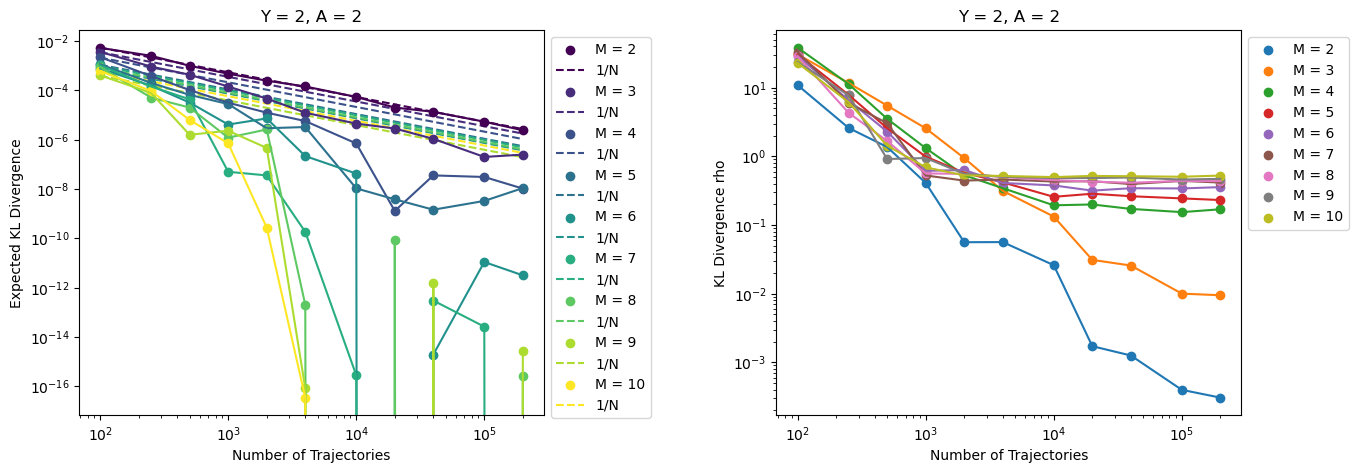

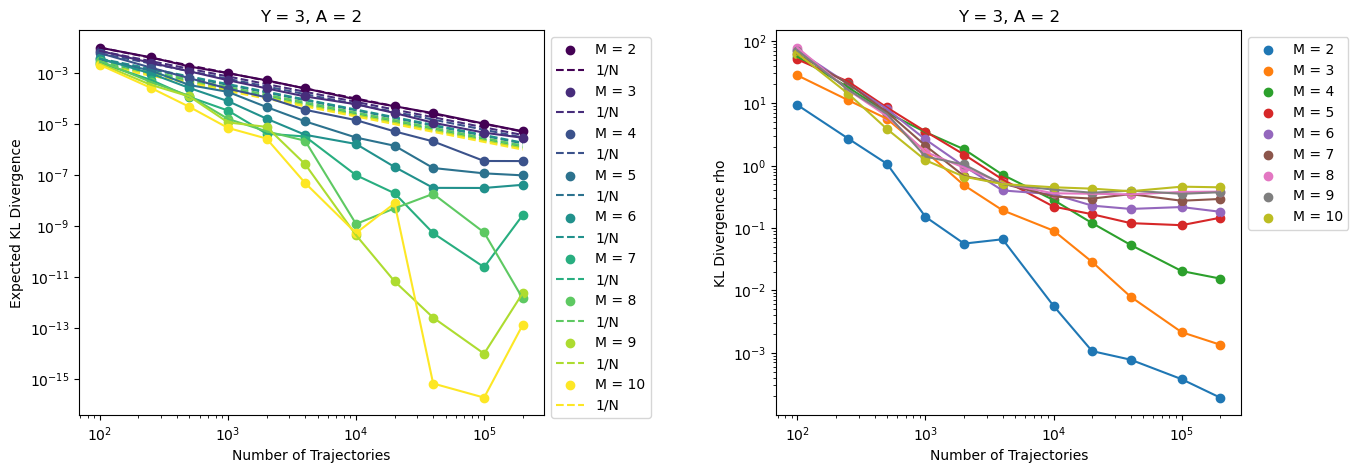

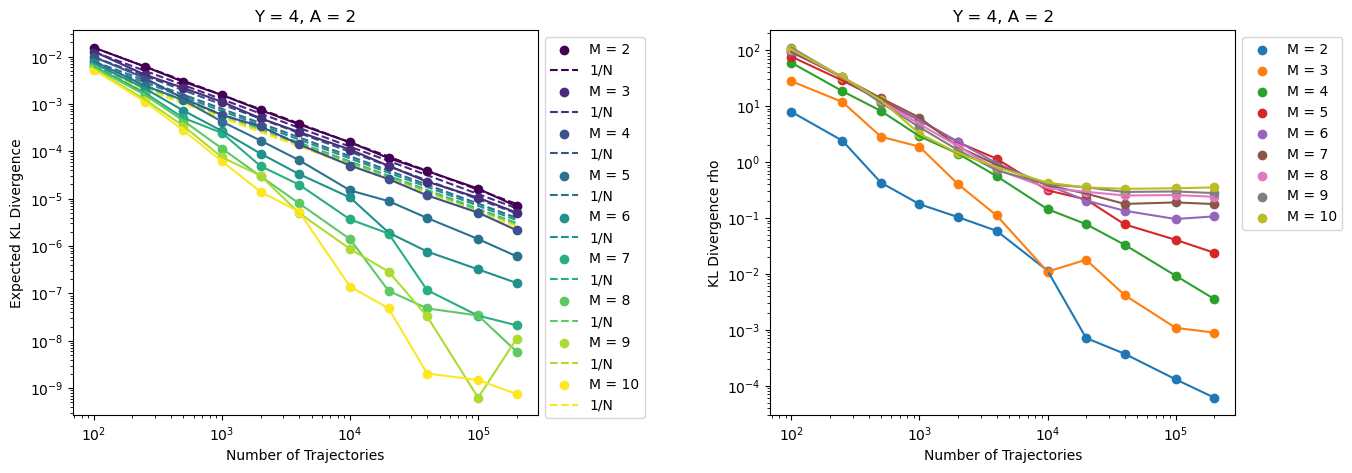

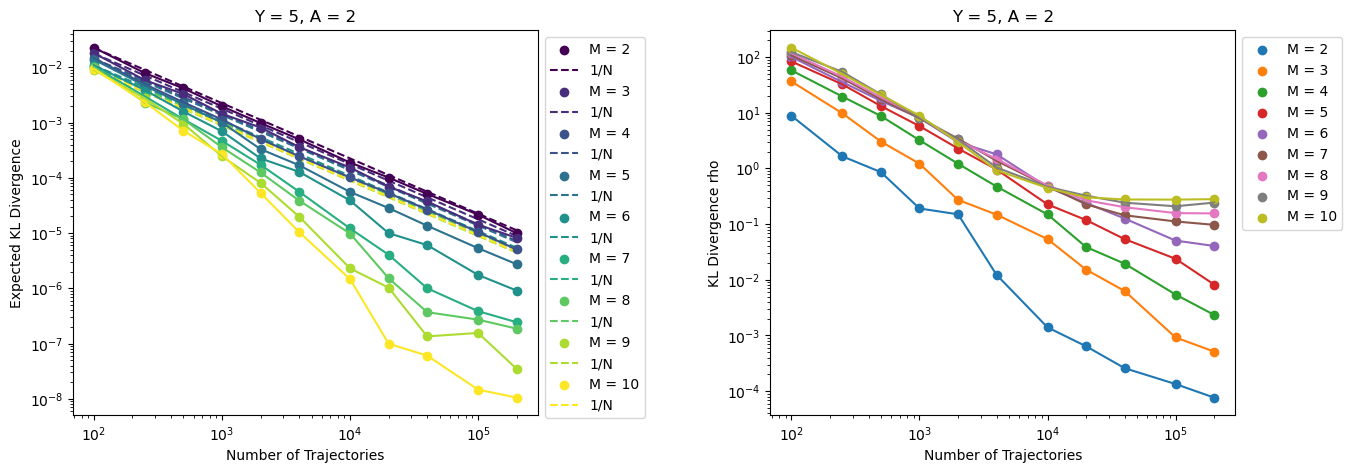

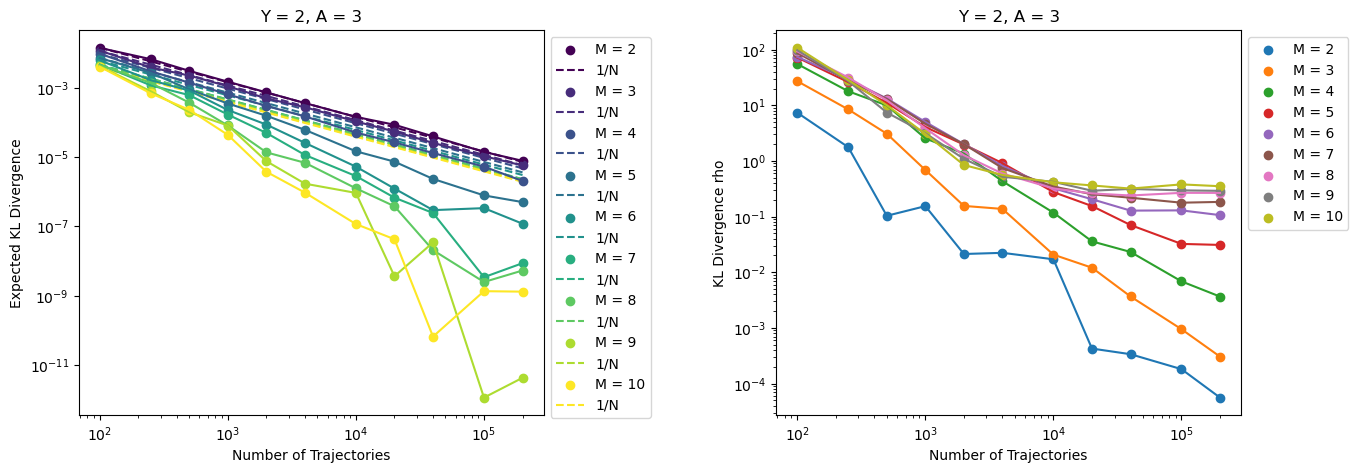

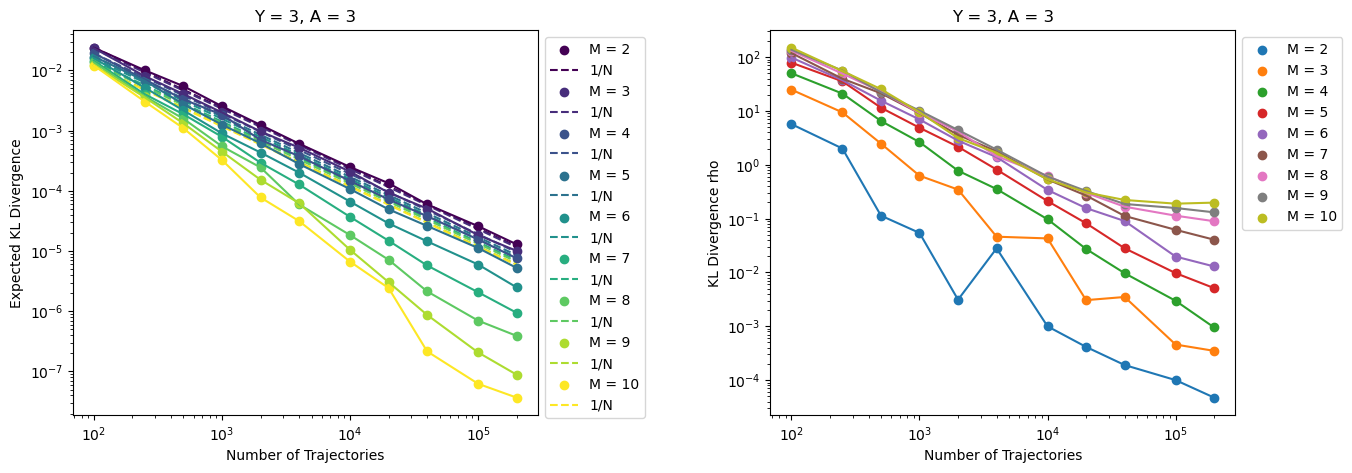

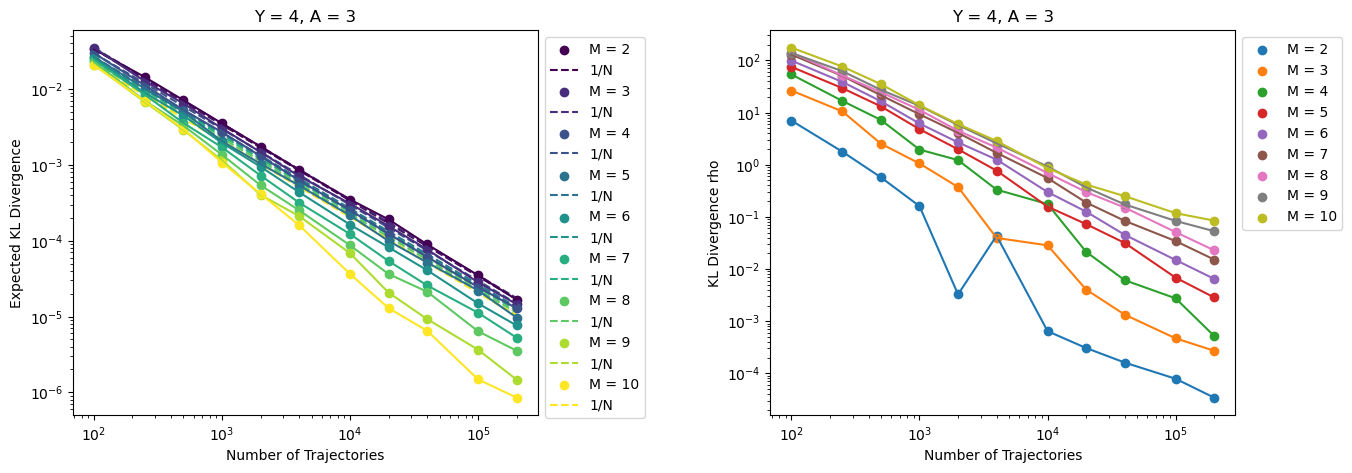

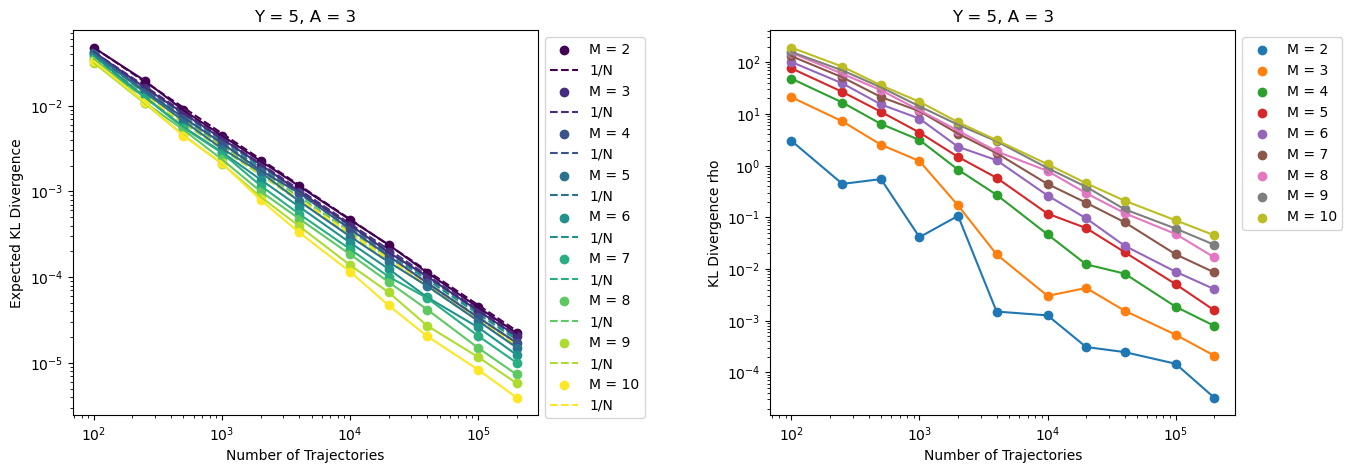

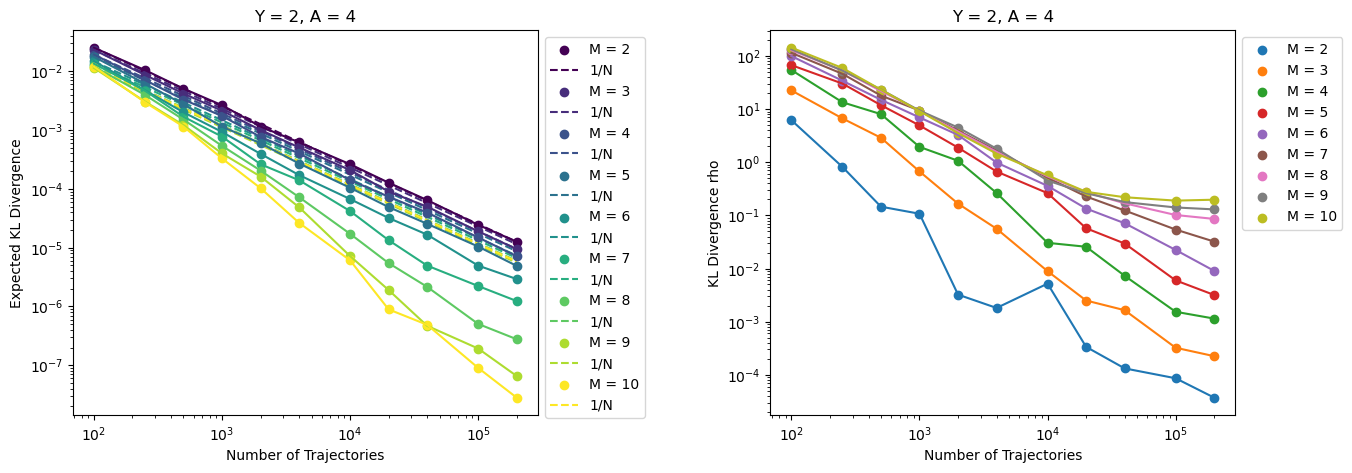

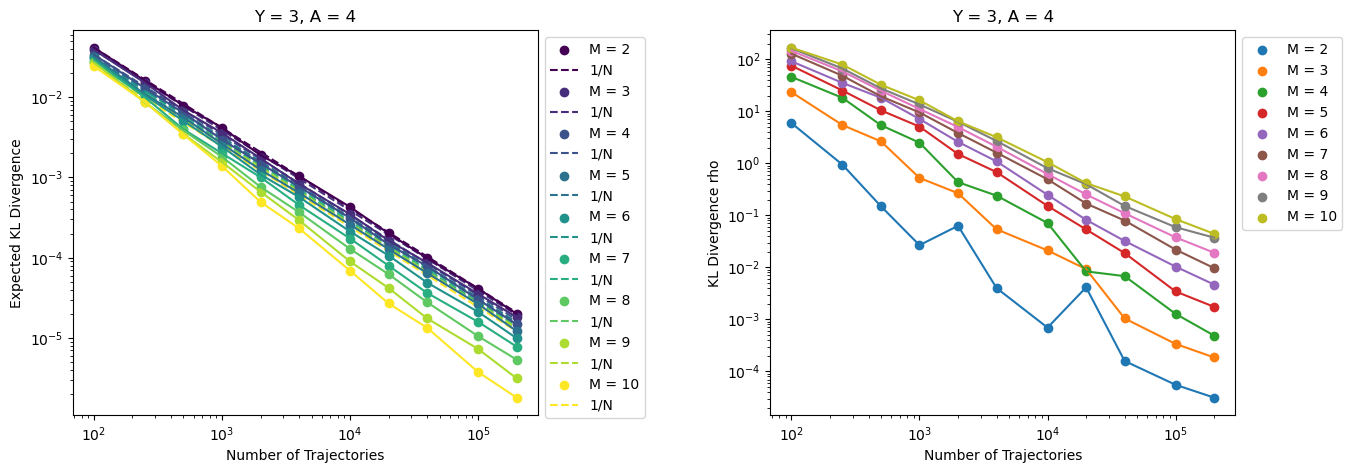

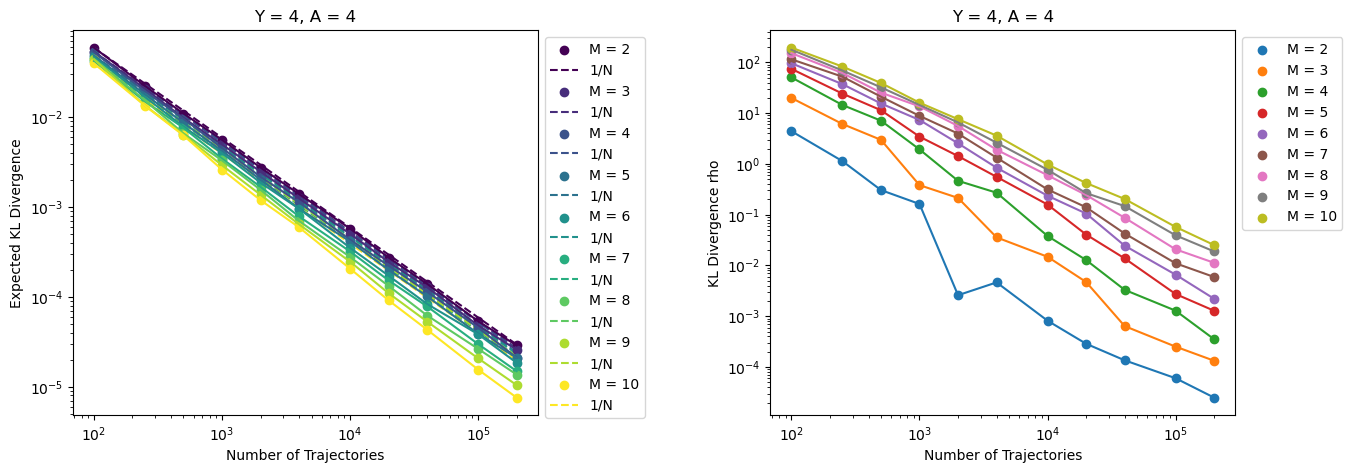

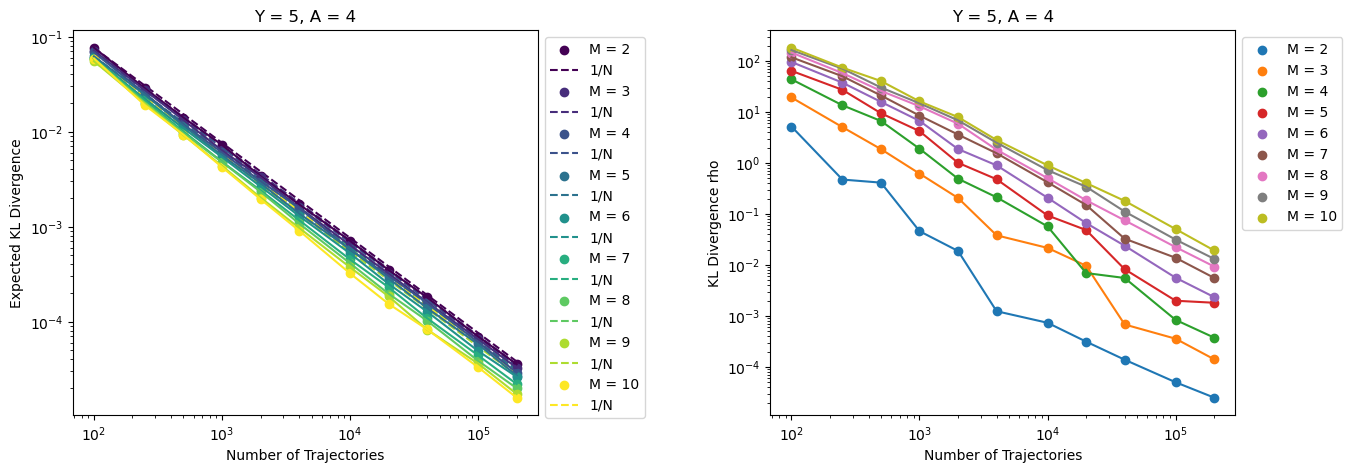

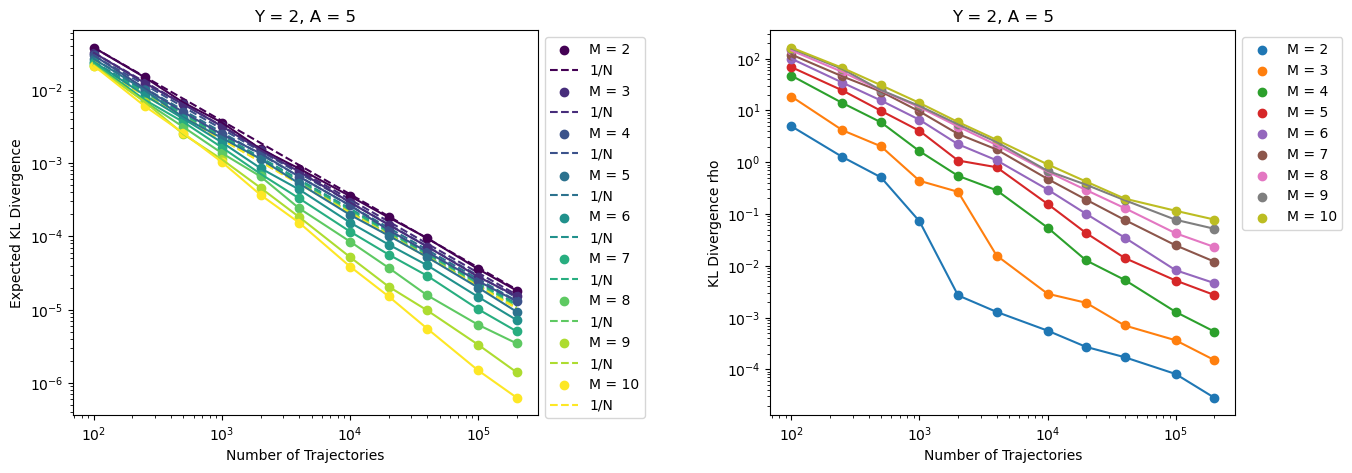

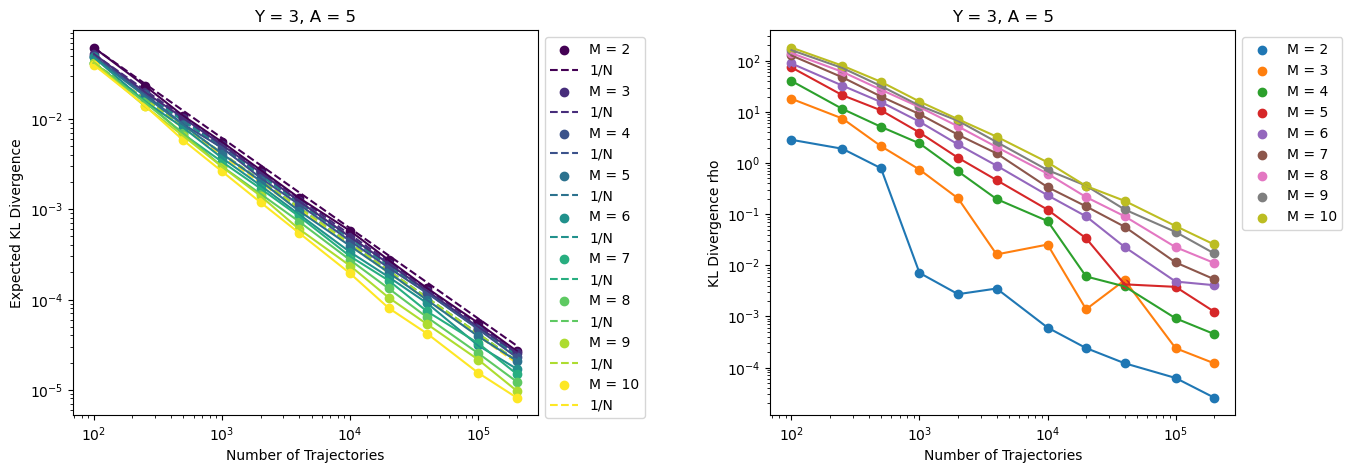

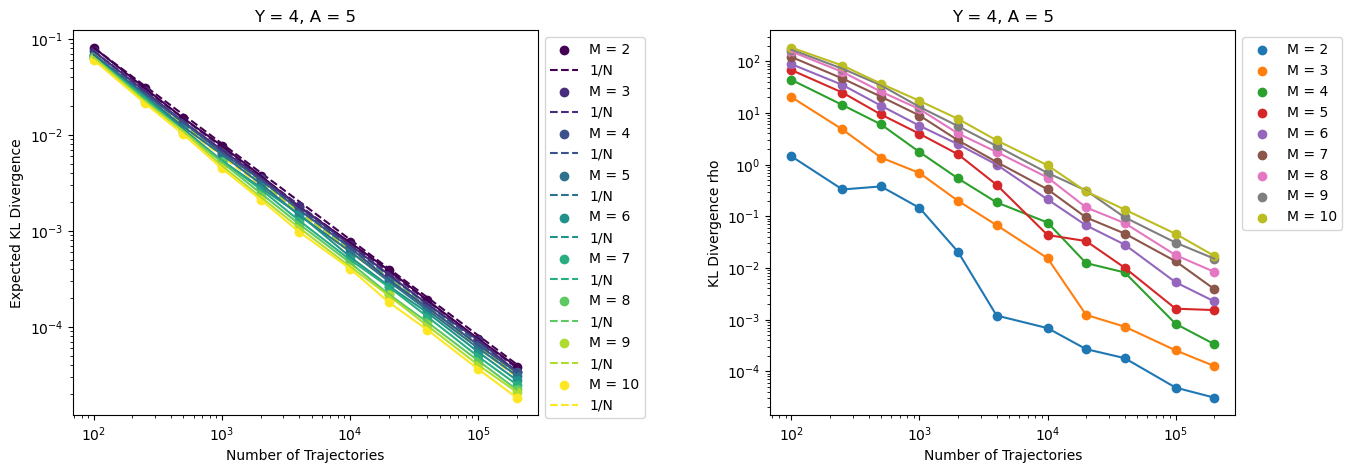

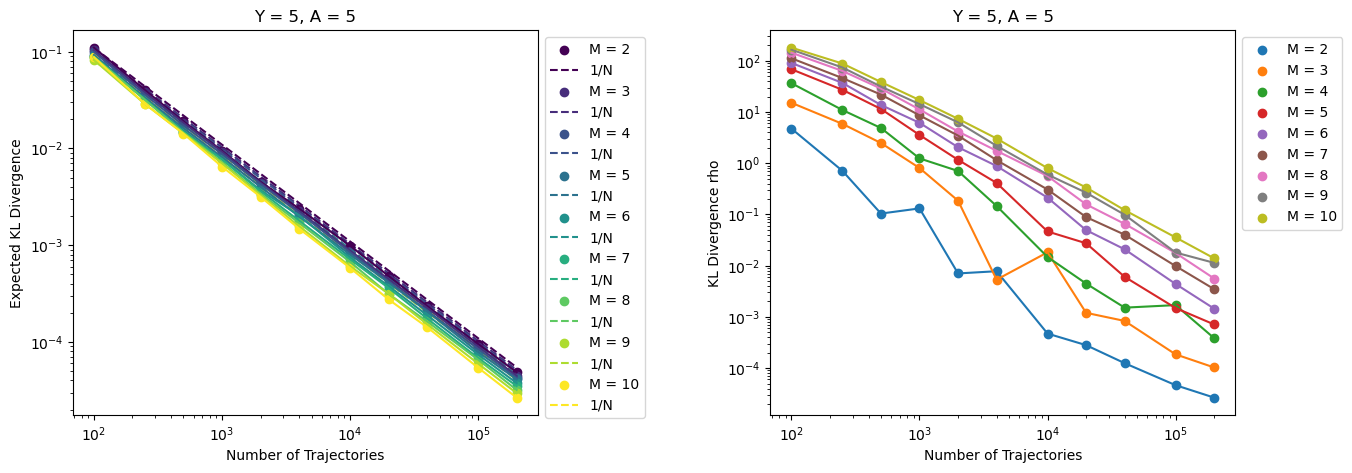

In [12]:
coefs_1N = np.zeros((len(Y_array), len(A_array), len(M_array)))

fun_1N = lambda x, a: a/x

colors_M = plt.cm.viridis(np.linspace(0,1,len(M_array)))

for idx_a, A in enumerate(A_array):
    for idx_y, Y in enumerate(Y_array):
        fig, axs = plt.subplots(1,2, figsize = (15,5))

        ax = axs[0]
        ax.set_title(f'Y = {Y}, A = {A}')

        
        for idx_m, M in enumerate(M_array):
            current_L = L[idx_y, idx_a, idx_m]

            #plt.errorbar(NTraj_array, np.mean(current_L, axis = 1), yerr = np.std(current_L, axis = 1), label = f'Y = {Y}, A = {A}, M = {M}')
            ax.scatter(NTraj_array, np.nanmean(current_L, axis = 1), label = f'M = {M}', color = colors_M[idx_m])
            ax.plot(NTraj_array, np.nanmean(current_L, axis = 1), color = colors_M[idx_m])

            coefs_1N[idx_y, idx_a, idx_m] = np.polyfit(1/NTraj_array, np.nanmean(current_L, axis = 1), 1)[0]
            ax.plot(NTraj_array, coefs_1N[idx_y, idx_a, idx_m]/NTraj_array, label = '1/N', linestyle = '--', color = colors_M[idx_m], zorder = -1)

        ax.legend(bbox_to_anchor = (1,1))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of Trajectories')
        ax.set_ylabel('Expected KL Divergence')

        
        ax = axs[1]
        ax.set_title(f'Y = {Y}, A = {A}')
        for idx_m, M in enumerate(M_array):
            current_L = DKL_rho[idx_y, idx_a, idx_m]

            #plt.errorbar(NTraj_array, np.mean(current_L, axis = 1), yerr = np.std(current_L, axis = 1), label = f'Y = {Y}, A = {A}, M = {M}')
            ax.scatter(NTraj_array, np.nanmean(current_L, axis = 1), label = f'M = {M}')
            ax.plot(NTraj_array, np.nanmean(current_L, axis = 1))

        ax.legend(bbox_to_anchor = (1,1))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of Trajectories')
        ax.set_ylabel('KL Divergence rho')

        plt.subplots_adjust(wspace = 0.5)
        plt.show()

In [18]:
coefs_1N[-1, -1]

array([10.91588339, 10.2601437 ,  9.83204386,  9.14789599,  8.88240613,
        8.6880908 ,  8.75657724,  8.11109911,  8.64864194])

In [11]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter):

    Y, M, _, A = TMat.shape

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for _ in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        rhok_new /= np.sum(rhok_new)

        rhok = rhok_new

    return rhok

In [12]:
@nb.njit
def log_zero(x):
    y = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] != 0:
            y[i] = np.log(x[i])
    return y

In [42]:
NStepsObs = 1
NSteps = NStepsObs

MaxIter = 100000

A = 2
Y = 2
M = 10

RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)


NTraj_array = np.array([10000, 50000, 100000, int(1e6), int(1e7)])
Ltest = np.zeros(NTraj_array.size)
rho_true = np.zeros((NTraj_array.size, M))
rho_fit = np.zeros((NTraj_array.size, M))

DKL_rho = np.zeros(NTraj_array.size)

for idx_traj, NTraj in enumerate(NTraj_array):

    observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs)
    Theta = np.random.randn(Y, M, M, A)
    Psi = np.random.randn(M)

    FSC = FSC_DiscreteObs(Theta, Psi, verbose = False)
    FSC.load_observations(observations)

    trajectories = FSC.generate_trajectories(NSteps)

    ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories])

    hist = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(Y+1), np.arange(A+1)])[0]
    pya = hist / np.sum(hist)
    pAgY = pya / np.sum(pya, axis = 1)[:, None]

    rhostart = np.random.rand(M)
    rhostart /= np.sum(rhostart)

    rho_opt = optimize_rho(FSC.TMat, pya, rhostart, MaxIter)
    print(FSC.rho, rho_opt)
    print()

    wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)
    Ltest[idx_traj] = np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1)))

    rho_true[idx_traj] = FSC.rho
    rho_fit[idx_traj] = rho_opt

    DKL_rho[idx_traj] = np.sum(FSC.rho*(log_zero(FSC.rho) - log_zero(rho_opt)))

[0.08623199 0.26683307 0.05761604 0.22847303 0.04915755 0.02608631
 0.02903037 0.04893675 0.01867038 0.1889645 ] [0.19892467 0.17490732 0.032293   0.02633147 0.13146239 0.15120127
 0.1213254  0.01065481 0.10484023 0.04805944]

[0.02017922 0.01367954 0.03421782 0.10484516 0.08793816 0.0243006
 0.00997017 0.02324581 0.35216522 0.32945829] [0.00233711 0.12086773 0.10270529 0.04050674 0.23923633 0.03752661
 0.04816703 0.01090463 0.30860563 0.08914289]

[0.0479284  0.08481958 0.03923364 0.02139217 0.03860115 0.08615831
 0.52129678 0.02254649 0.03373809 0.10428539] [0.00614069 0.01751361 0.23080422 0.15383755 0.08438763 0.04502036
 0.21756623 0.02108364 0.13014552 0.09350055]

[0.03337197 0.35605983 0.03749926 0.09598414 0.13135691 0.04252874
 0.08548608 0.02119896 0.02298297 0.17353113] [0.0506624  0.1254645  0.12045765 0.15876158 0.09269242 0.0934105
 0.12154278 0.13221242 0.03647124 0.06832451]

[0.01385932 0.07605737 0.0401766  0.17674781 0.0083415  0.20713331
 0.02873113 0.3025494  0.05

In [43]:
DKL_rho

array([0.73302171, 0.45628766, 0.56915984, 0.35998232, 0.3830821 ])

In [13]:
@nb.njit
def optimize_rho_all(TMat, pya, rhok, maxiter):

    Y, M, _, A = TMat.shape

    rhok_all = np.zeros((maxiter, M))
    rhok_all[0] = rhok

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for j in range(maxiter - 1):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok_all[j])
        
        grad = wVec * rhok_all[j] / wsumexp_test_k[..., None]

        for y in range(Y):
            for a in range(A):
                rhok_all[j + 1] += pya[y, a] * grad[y, a]
        
        rhok_all[j + 1] /= np.sum(rhok_all[j + 1])

    return rhok_all

In [21]:
NStepsObs = 1
NSteps = NStepsObs

MaxIter = 100000

A = 2
Y = 2
M = 10

RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)


NTraj = int(1e7)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs)
Theta = np.random.randn(Y, M, M, A)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = False)
FSC.load_observations(observations)

trajectories = FSC.generate_trajectories(NSteps)

ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories])

hist = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(Y+1), np.arange(A+1)])[0]
pya = hist / np.sum(hist)
pAgY = pya / np.sum(pya, axis = 1)[:, None]

rhostart = np.random.rand(M)
rhostart /= np.sum(rhostart)

rho_opt_all = optimize_rho_all(FSC.TMat, pya, rhostart, MaxIter)
rho_opt = rho_opt_all[-1]
print(FSC.rho, rho_opt)
print()

wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)
print(np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt), axis = -1))))

[0.06490712 0.09461489 0.06129722 0.19301448 0.12349809 0.04290102
 0.05907017 0.0548995  0.27851002 0.02728749] [0.21310879 0.13618712 0.08947286 0.06564591 0.26120745 0.02048774
 0.07027207 0.05733529 0.06721854 0.01906424]

5.305389461085494e-17


In [22]:
print(np.sum(FSC.rho*(log_zero(FSC.rho) - log_zero(rho_opt))))

0.40560083291567717


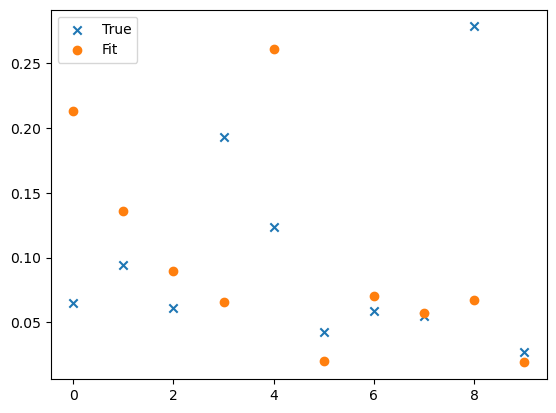

In [29]:
plt.scatter(np.arange(M), FSC.rho, label = 'True', marker = 'x')
plt.scatter(np.arange(M), rho_opt, label = 'Fit')
plt.legend()
plt.show()

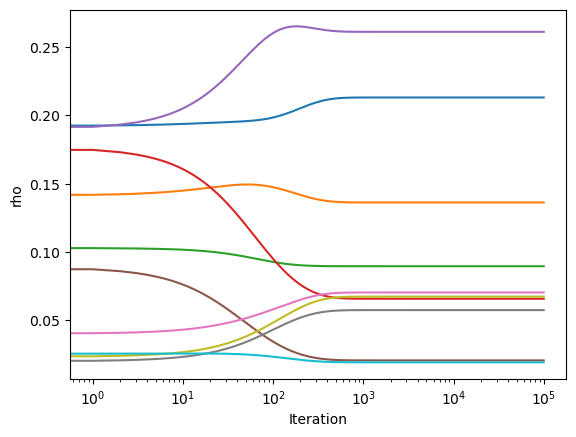

In [24]:
plt.plot(rho_opt_all)
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('rho')
plt.show()

In [25]:
rhostart2 = np.ones(M)/M

rho_opt_all2 = optimize_rho_all(FSC.TMat, pya, rhostart2, MaxIter)
rho_opt2 = rho_opt_all2[-1]
print(FSC.rho, rho_opt2)
print()

print(np.sum(pya*np.log(pAgY/np.sum((wVec*rho_opt2), axis = -1))))

[0.06490712 0.09461489 0.06129722 0.19301448 0.12349809 0.04290102
 0.05907017 0.0548995  0.27851002 0.02728749] [0.1005862  0.09678416 0.09469184 0.0767413  0.1054777  0.0683434
 0.11245002 0.12677148 0.12719416 0.09095975]

0.0


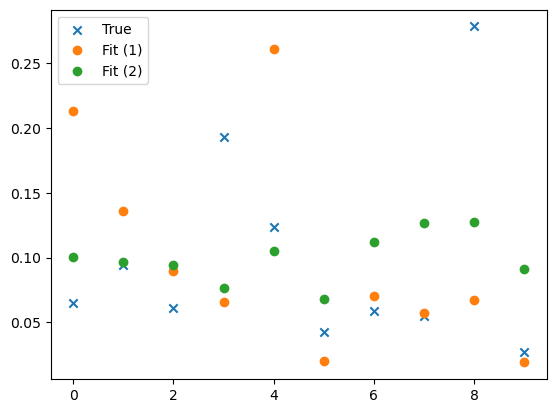

In [28]:
plt.scatter(np.arange(M), FSC.rho, label = 'True', marker = 'x')
plt.scatter(np.arange(M), rho_opt, label = 'Fit (1)')
plt.scatter(np.arange(M), rho_opt2, label = 'Fit (2)')
plt.legend()
plt.show()

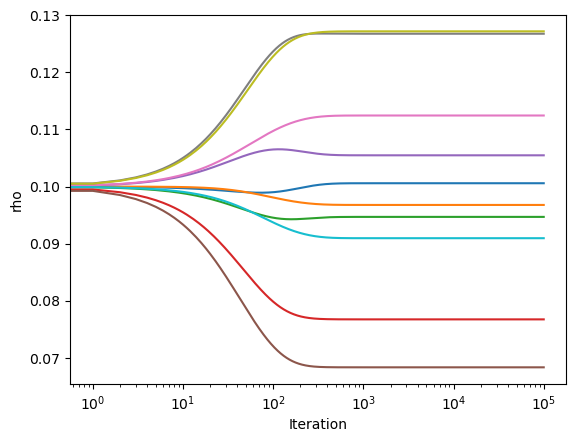

In [26]:
plt.plot(rho_opt_all2)
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('rho')
plt.show()